In [1]:
import os
import nltk
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

In [2]:
# Initialize the emotion classification pipeline
emotion_classifier = pipeline('text-classification', model='SamLowe/roberta-base-go_emotions', truncation=True)

C:\Users\deeda\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# Directory containing text files
directory_path = r"C:\Users\deeda\Desktop\Brandeis\Second Year\Lab rotation\emotional content\group1_transcripts"

In [4]:
# Processing a single text file for emotion analysis by sentences
def process_file(file_path):
    """
    Args:
        file_path (str): The path to the text file.
    Returns:
        list: A list of dictionaries with sentence, detected emotion, and score.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    sentences = nltk.tokenize.sent_tokenize(text)
    emotions = [emotion_classifier(sentence) for sentence in sentences]

    results = [{'sentence': sentence, 'emotion': emotion[0]['label'], 'score': emotion[0]['score']} for sentence, emotion in zip(sentences, emotions)]
    return results

In [5]:
# Processing each text file in a directory for emotion analysis.
def process_directory(directory):
    """
    Returns:
        pd.DataFrame: A DataFrame containing the results for all files.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            file_results = process_file(file_path)
            for res in file_results:
                res['filename'] = filename  # Include filename (or subject ID) in results
            results.extend(file_results)

    return pd.DataFrame(results)

In [6]:
# Processing the directory and save results to a DataFrame
df_emotions = process_directory(directory_path)

In [7]:
# Save the results to a CSV file
output_csv_path = os.path.join(directory_path, '28_emotion_analysis_results.csv')
df_emotions.to_csv(output_csv_path, index=False)

print(f"Emotion analysis completed and saved to {output_csv_path}")

Emotion analysis completed and saved to C:\Users\deeda\Desktop\Brandeis\Second Year\Lab rotation\emotional content\group1_transcripts\28_emotion_analysis_results.csv


In [8]:
# Group by filename and emotion, then count occurrences
emotion_counts = df_emotions.groupby(['filename', 'emotion']).size().reset_index(name='count')

# Calculate total emotions per file
total_emotions_per_subject = emotion_counts.groupby('filename')['count'].sum().reset_index(name='total_count')

# Merge to get total count per subject alongside emotion counts
emotion_counts = emotion_counts.merge(total_emotions_per_subject, on='filename')

In [9]:
# Calculate percentage of each emotion per subject
emotion_counts['percentage'] = (emotion_counts['count'] / emotion_counts['total_count']) * 100

# Save the results with percentages
emotion_counts.to_csv(os.path.join(directory_path, 'emotion_percentages_per_subject.csv'), index=False)

print("Emotion percentages per subject calculated and saved.")

Emotion percentages per subject calculated and saved.


Arousal Classification

In [10]:
arousal_mapping = {
    "admiration": "low",
    "amusement": "low",
    "anger": "high",
    "annoyance": "high",
    "approval": "low",
    "caring": "low",
    "confusion": "high",
    "curiosity": "low",
    "desire": "high",
    "disappointment": "low",
    "disapproval": "high",
    "disgust": "high",
    "embarrassment": "low",
    "excitement": "high",
    "fear": "high",
    "gratitude": "low",
    "grief": "low",
    "joy": "high",
    "love": "low",
    "nervousness": "high",
    "optimism": "low",
    "pride": "high",
    "realization": "low",
    "relief": "low",
    "remorse": "low",
    "sadness": "low",
    "surprise": "high",
    "neutral": "low"   
}


In [11]:
#processing function
##excluding neutral

def classify_arousal(emotion):
    """Classify the given emotion into an arousal category, excluding 'neutral'."""
    if emotion == 'neutral':
        return 'neutral'  # Treat 'neutral' distinctly
    return arousal_mapping.get(emotion, "unknown")

def process_file(file_path):
    """
    Args:
        file_path (str): The path to the text file.
    Returns:
        list: A list of dictionaries with sentence, detected emotion, score, and arousal category (excluding neutral).
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()

    sentences = nltk.tokenize.sent_tokenize(text)
    emotions = [emotion_classifier(sentence) for sentence in sentences]
    results = []
    for sentence, emotion in zip(sentences, emotions):
        emotion_label = emotion[0]['label']
        if emotion_label != 'neutral':  # Exclude 'neutral' from arousal category analysis
            arousal_category = classify_arousal(emotion_label)
        else:
            arousal_category = 'neutral'
        results.append({
            'sentence': sentence,
            'emotion': emotion_label,
            'score': emotion[0]['score'],
            'arousal': arousal_category
        })
    return results

In [12]:
# Processing the directory and save results to a DataFrame
df_arousal = process_directory(directory_path)

# Save the results to a CSV file
output_csv_path = os.path.join(directory_path, 'emotion_arousal_analysis_results.csv')
df_arousal.to_csv(output_csv_path, index=False)

print(f"Emotion and arousal analysis completed and saved to {output_csv_path}")

Emotion and arousal analysis completed and saved to C:\Users\deeda\Desktop\Brandeis\Second Year\Lab rotation\emotional content\group1_transcripts\emotion_arousal_analysis_results.csv


In [13]:
# Filter out entries where arousal is 'neutral'
df_arousalX = df_arousal[df_arousal['arousal'] != 'neutral']

# Group by filename and arousal category, and count occurrences
arousal_countsX = df_arousalX.groupby(['filename', 'arousal']).size().unstack(fill_value=0)

# Optional: Save the arousal counts to a CSV file
arousal_countsX_csv_path = os.path.join(directory_path, 'arousal_counts_per_subject_without_neutral.csv')
arousal_countsX.to_csv(arousal_countsX_csv_path)

print(f"Arousal category counts per subject (excluding neutral) saved to {arousal_countsX_csv_path}")

Arousal category counts per subject (excluding neutral) saved to C:\Users\deeda\Desktop\Brandeis\Second Year\Lab rotation\emotional content\group1_transcripts\arousal_counts_per_subject_without_neutral.csv


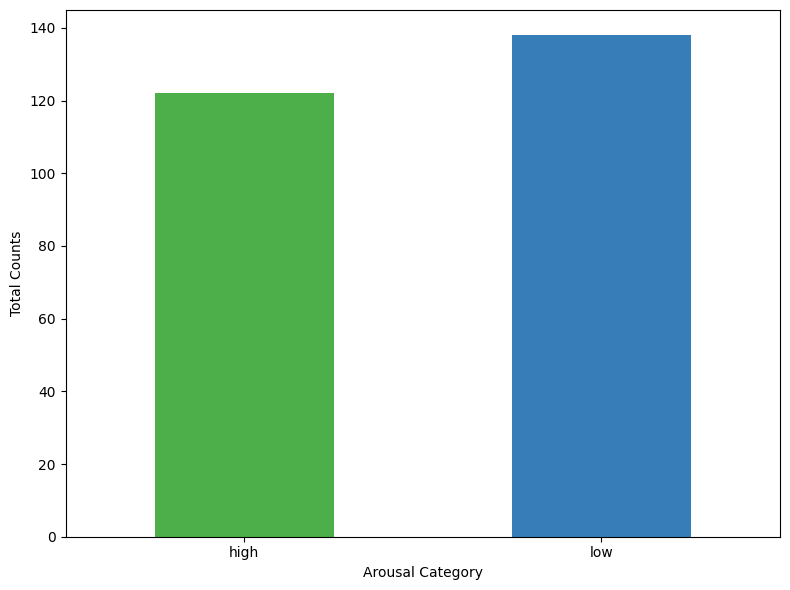

In [14]:
# Sum the counts of arousal categories across all subjects
total_arousal_countsX = arousal_countsX.sum()

total_arousal_countsX.plot(kind='bar', color=['#4daf4a', '#377eb8'], figsize=(8, 6))

# Add labels and title
plt.xlabel('Arousal Category')
plt.ylabel('Total Counts')
plt.title('')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal for better readability

# Show the plot
plt.tight_layout()
plt.show()